In [855]:
# now we are using MLP, instead of simply looking at a bigram model which is inefficient
# probability is expressed as a conditional probability of the next character given all of the previous ones, parameters are tuned to maximize the log likelihood of the training data
# tune these weights using backpropogation


In [856]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [857]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [858]:
len(words)

32033

In [859]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [860]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [861]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [862]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [863]:
X.shape

torch.Size([228146, 3])

In [864]:
Y.shape

torch.Size([228146])

In [865]:
C = torch.randn((27,2))

In [866]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [867]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [868]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [869]:
h

tensor([[ 0.9358, -0.7205, -0.5806,  ...,  0.9171, -0.9955,  0.8986],
        [ 0.9770,  0.8798, -0.6296,  ...,  0.9711, -0.9976,  0.8509],
        [-0.9747, -0.9693,  0.9611,  ..., -0.6661, -0.9131,  0.9950],
        ...,
        [ 0.9977,  1.0000, -0.9989,  ...,  0.8787, -0.9973, -0.9999],
        [-0.3101, -1.0000,  0.9998,  ...,  0.0883,  0.0904,  0.9784],
        [ 0.9998,  1.0000, -1.0000,  ...,  0.9984, -1.0000,  0.9997]])

In [870]:
h.shape

torch.Size([228146, 100])

In [871]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [872]:
logits = h @ W2 + b2

In [873]:
logits.shape

torch.Size([228146, 27])

In [874]:
counts = logits.exp()

In [875]:
prob = counts / counts.sum(1, keepdims=True)

In [876]:
prob.shape

torch.Size([228146, 27])

In [877]:
loss = -prob[torch.arange(32), Y].log().mean()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
loss

tensor(20.5692, grad_fn=<NllLossBackward0>)

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [ ]:
# same thing but use cross entropy function in pytorch
# this allows forward/backward pass to be much more efficient
# this is the forward pass

In [ ]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10 ), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
for p in parameters:
    p.requires_grad = True
    

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x30 and 6x100)

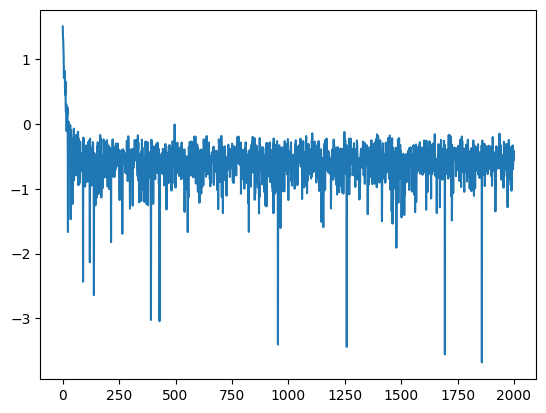

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (228146x30 and 6x100)

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (22767x30 and 6x100)

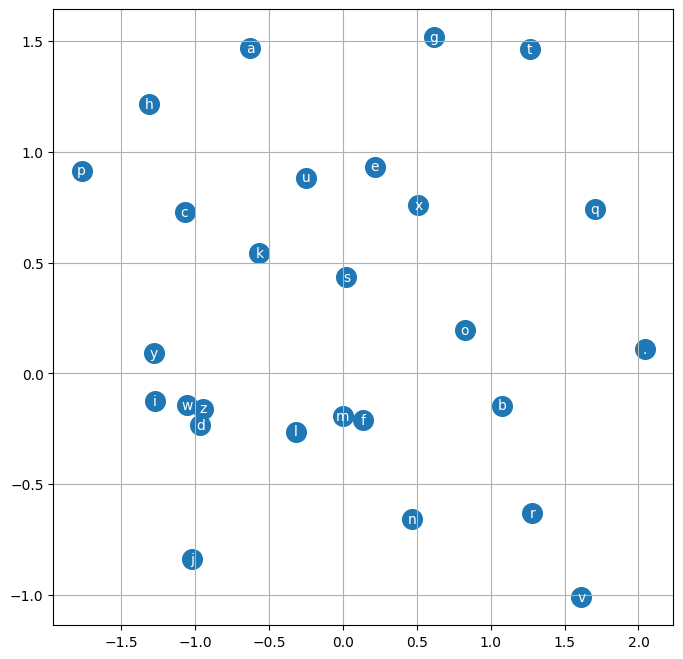

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range (C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x30 and 6x100)

In [ ]:
logits

tensor([[ 35.6049,  10.5670,  -4.6727,  11.0882,  20.2586,  20.7505,   0.1643,
          16.5637,  22.5837,   4.7333,   3.7788,  -0.4472,  -4.8415,  13.7390,
         -27.0829,   6.1506,  -5.7010,  -8.0219,   2.2191,  -0.5825,   2.9401,
           1.6809,   6.3348, -30.3615, -10.4844,  10.4885,  -4.2740]],
       grad_fn=<AddBackward0>)

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [ ]:
emb.shape

torch.Size([32, 3, 2])

In [ ]:
emb.view(32,6)

tensor([[-0.4344, -0.1999, -0.4344, -0.1999, -0.4344, -0.1999],
        [-0.4344, -0.1999, -0.4344, -0.1999,  0.1317,  0.7598],
        [-0.4344, -0.1999,  0.1317,  0.7598,  0.3615, -0.1694],
        [ 0.1317,  0.7598,  0.3615, -0.1694,  0.3615, -0.1694],
        [ 0.3615, -0.1694,  0.3615, -0.1694, -0.7433, -0.6197],
        [-0.4344, -0.1999, -0.4344, -0.1999, -0.4344, -0.1999],
        [-0.4344, -0.1999, -0.4344, -0.1999, -1.0177,  0.1845],
        [-0.4344, -0.1999, -1.0177,  0.1845,  0.0659,  0.7223],
        [-1.0177,  0.1845,  0.0659,  0.7223,  0.7273,  0.2168],
        [ 0.0659,  0.7223,  0.7273,  0.2168,  0.6274, -0.9014],
        [ 0.7273,  0.2168,  0.6274, -0.9014,  0.7273,  0.2168],
        [ 0.6274, -0.9014,  0.7273,  0.2168, -0.7433, -0.6197],
        [-0.4344, -0.1999, -0.4344, -0.1999, -0.4344, -0.1999],
        [-0.4344, -0.1999, -0.4344, -0.1999, -0.7433, -0.6197],
        [-0.4344, -0.1999, -0.7433, -0.6197,  0.6274, -0.9014],
        [-0.7433, -0.6197,  0.6274, -0.9